# Exemple de gestion d'énergie et de dimensionnement d'un micro-réseau

L'exemple est basé sur la gestion d'énergie et le dimensionneùent d'un micro-réseau contenant, des sources d'énergie renouvelables, des charges, et un système de stockage électrochimique. Le profile d'irradiation et la consomation de la charge sont supposées connues sur l'horizon considéré et les degrés de libertés sont :
    
- le dimensionnement du stockage (i.e. c_bat),
- le dimensionnement des panneaux photovoltaïques (i.e. la surface), 
- les flux de puissances provenant du réseau et du stockage. 


<img src="data/figures/microgrids_bat.png" style="height:250px">


La première étape consiste à charger les bibliothèques utiles:

- Pyomo : le package de modélisation des problèmes d'optimisation (voir https://pyomo.readthedocs.io/en/latest/)
- lms2 : la librairie maison de modèles pour la gestion d'énerge et l'optimisation en génie électrique (documentation dans `lms2/docs/_build/html/index.html`). Dans ce package on ira chercher les modèles que l'on souhaite utiliser, dans le cas qui nous intéresse battery_v2 (avec efficacité en charge et décharge), pv_panel, etc.

In [1]:
from pyomo.dae import ContinuousSet, Integral
from pyomo.environ import *
from lms2.core.horizon import SimpleHorizon
from lms2.electric.batteries import battery_v2
from lms2.electric.sources import pv_panel, fixed_power_load, power_source

Cet exemple d'optimisation illustre les étapes suivantes :

1. Instanciation du problème d'optimisation et de l'horizon temporel
2. Discrétisation temporelle
3. Chargement des données
4. Résolution

## Instanciation du problème d'optimisation et de l'horizon temporel

L'instanciation du problème comporte plusieurs étapes :

1. Instanciation d'un problème nommé `m`.
2. Instanciation de l'horizon temporel, celui-ci fait le lien entre les indexes des vecteurs (en s) et les dates (sous forme `str`). Cet objet n'est pas toujours obligatoire, mais il est particulièrement utile pour le chargement de certaines données, la discrétisation temporelle et le post-processing (affichage, etc.).
3. Instanciation des variables, des paramètres et des équations du modèle :

    - par chargement de sous-modèles (blocks) déjà existants dans la librairie,
    - par modélisation avec le langage pyomo.

In [2]:
m = ConcreteModel()
horizon = SimpleHorizon(tstart='2020-01-01 00:00:00', tend='2020-01-02 00:00:00', time_step='10 min')
m.time = ContinuousSet(initialize=[0, horizon.horizon.total_seconds()])

print("les 5 premiers instants considérés :\n", horizon.current[0:5]) #
print("les 5 premiers indexes (équivalents au temps en s) : \n", horizon.index[0:5]) 

les 5 premiers instants considérés :
 DatetimeIndex(['2020-01-01 00:00:00+01:00', '2020-01-01 00:10:00+01:00',
               '2020-01-01 00:20:00+01:00', '2020-01-01 00:30:00+01:00',
               '2020-01-01 00:40:00+01:00'],
              dtype='datetime64[ns, Europe/Paris]', freq='10T')
les 5 premiers indexes (équivalents au temps en s) : 
 [   0.  600. 1200. 1800. 2400.]


Les blocks sont des sous-problèmes qui permettent de définir, pour chaque composant, des variables, des paramètres, des contraintes et des expressions.

Il est possible de rentrer des options en argument. Les grandeurs dynamiques seront chargés plus tard, l'utilisation de dictionnaire n'est pas pratique dans ce cas, et le temps n'a pas encore été discrétisé...

In [3]:
option_bat = {'time': m.time, 'c_bat': 2000, 'eta_c': 0.95, 'eta_d': 0.95, 'soc_min': 40, 'soc_max': 95}
option_charge = {'time': m.time}
option_pv = {'time': m.time, 's_max': 10, 's_min': 1}
option_pv = {'time': m.time, 's_max': 10, 's_min': 1}
option_res = {'time': m.time}

Les options des blocks sont (généralement) définis dans la documentation de chaque block,

In [4]:
help(battery_v2)

Help on function battery_v2 in module lms2.electric.batteries:

battery_v2(bat, **options)
    Bilinear battery Model.
    
    This battery is limited in power, variation of power, state of charge and energy. One can fix initial and final
    state of charge.
    Efficiency for charge and discharge are considered.
    It exposes one power port using source convention.
    
    Instanciation options:
        - c_bat : battery capacity (kWh)
        - c_bat_max : battery maximal capacity, default : +inf (only if c_bat is None)
        - c_bat_min : battery minimal capacity, default : 0 (only if c_bat is None)
        - p_max : maximal charging power, default : +inf (>0)
        - p_min : maximal descharging power, default : +inf (>0)
        - soc_min : minimal soc, default : 0 (>0)
        - soc_max : maximal soc, default : 100 (>0)
        - eta_c : charging efficiency, default : 1 (<1 and >0)
        - eta_d : descharging efficiency, default : 1 (<1 and >0)
    
    =============== =

In [5]:
m.bat = Block(rule=lambda x: battery_v2(x, **option_bat))
m.charge = Block(rule=lambda x: fixed_power_load(x, **option_charge))
m.pv = Block(rule=lambda x: pv_panel(x, **option_pv))
m.res = Block(rule=lambda x: power_source(x, **option_res))

A ce stade, les blocks sont instancié dans le problème `m`. Il est possible de vérifier la structure du modèle avec la commande `pprint()`. Notez que certaines grandeurs ne sont pas initialisées à la valeur que l'on souhaiterait, pour le moment.

In [6]:
m.bat.pprint()

bat : Size=1, Index=None, Active=True
    13 Param Declarations
        dpcmax : maximal charging power
            Size=1, Index=None, Domain=Reals, Default=10000000.0, Mutable=True
            Key  : Value
            None : 10000000.0
        dpdmax : maximal discharging power
            Size=1, Index=None, Domain=Reals, Default=10000000.0, Mutable=True
            Key  : Value
            None : 10000000.0
        emax : maximal energy
            Size=1, Index=None, Domain=Reals, Default=2000, Mutable=True
            Key  : Value
            None :  2000
        emin : minimum energy (kWh)
            Size=1, Index=None, Domain=NonNegativeReals, Default=0, Mutable=True
            Key  : Value
            None :     0
        etac : charging efficiency
            Size=1, Index=None, Domain=Reals, Default=0.95, Mutable=True
            Key : Value
        etad : discharging efficiency
            Size=1, Index=None, Domain=Reals, Default=0.95, Mutable=True
            Key : Valu

#### Exemple de contrainte sur le bilan de puissance

La connexion électrique des blocks entre eux peut être vue comme une contrainte d'égalité, appelée bilan de puissance. Elle doit être définie en dehors des blocks, (i.e. au niveau du model m).
Pour se faire il y a deux possibilités :
- définir une contrainte classique avec le langague de pyomo,
- utiliser la notion de ports (extensifs ou intensifs) (usage un peu plus avancé).
  

In [7]:
@m.Constraint(m.time)
def bilan_puissance(b, t):
    return b.bat.p[t] + b.res.p[t] + b.pv.p_scaled[t] == b.charge.p[t]

#### Exemple d'une expression
Il est possible de définir des expressions, qui interviendront potentiellement
dans les calculs des coûts, des contraintes ou pour le post-processing. Pour l'exemple, définissons les couts instantanés économiques `cout_inst_edf` et écologiques `cout_inst_env`.

In [8]:
@m.Expression(m.time)
def cout_inst_env(b, t):
    return 60*b.bat.p[t] + 60*b.pv.p_scaled[t] + 700*b.res.p[t]


@m.Expression(m.time)
def cout_inst_edf(b, t):
    return 0.15*b.res.p[t]

#### Exemple d'intégration temporelle
Lorsqu'une expression doit être intégrée sur le temps continu, on utilise l'objet `Integral`. L'intégration des couts sur le temps devient : 

In [9]:
m.int_edf = Integral(m.time, wrt=m.time, rule=cout_inst_edf)
m.int_env = Integral(m.time, wrt=m.time, rule=cout_inst_env)

#### Exemple de définition de l'objectif
L'objectif d'optimisation doit être défini au niveau du model `m` et peut faire intervenir
les variables des sous-blocks. Dans le language Pyomo, on utilise l'objet `Objective`.

In [10]:
@m.Objective()
def cout_edf(b):
    return b.int_edf + 100*b.bat.emax/(m.time.last() - m.time.first())/(20*365*24*60) + 100*b.pv.s/(m.time.last() - m.time.first())/(20*365*24*60)

## Discrétisation temporelle

La discrétisation temporelle est souvent source d'erreur, suivant le schéma d'intégration et sur des modèles de grande taille, cette étape devient difficilement réalisable à la main. Pour cela, l'extention Pyomo.dae offre la possibilité de discrétiser automatiquement les modèles dans lesquels apparait un index continu (généralement le temps). Ce qui rend les choses plus simples. Dans cet exemple on choisira un schéma d'intégration de différence finie (i.e. celui d'Euler).

Avant discrétisation, les grandeurs indexées par le temps ne font intervenir que le début et la fin de l'horizon.

In [11]:
# l'intégrale avant discrétisation :
m.int_edf.pprint()

int_edf : Size=1, Index=None
    Key  : Expression
    None : 43200.0*(0.15*res.p[86400.0] + 0.15*res.p[0])


Noter que la discrétisation se fait sur le modèle complet, en renseignant le nombre d'éléments finis. Dans notre cas, cette information est stockée dans l'objet `horizon`.

In [12]:
from pyomo.environ import TransformationFactory
TransformationFactory('dae.finite_difference').apply_to(m, nfe=horizon.nfe)

In [13]:
# l'intégrale après discrétisation :
m.int_edf.pprint()

int_edf : Size=1, Index=None
    Key  : Expression
    None : 300.0*(0.15*res.p[600.0] + 0.15*res.p[0]) + 300.0*(0.15*res.p[1200.0] + 0.15*res.p[600.0]) + 300.0*(0.15*res.p[1800.0] + 0.15*res.p[1200.0]) + 300.0*(0.15*res.p[2400.0] + 0.15*res.p[1800.0]) + 300.0*(0.15*res.p[3000.0] + 0.15*res.p[2400.0]) + 300.0*(0.15*res.p[3600.0] + 0.15*res.p[3000.0]) + 300.0*(0.15*res.p[4200.0] + 0.15*res.p[3600.0]) + 300.0*(0.15*res.p[4800.0] + 0.15*res.p[4200.0]) + 300.0*(0.15*res.p[5400.0] + 0.15*res.p[4800.0]) + 300.0*(0.15*res.p[6000.0] + 0.15*res.p[5400.0]) + 300.0*(0.15*res.p[6600.0] + 0.15*res.p[6000.0]) + 300.0*(0.15*res.p[7200.0] + 0.15*res.p[6600.0]) + 300.0*(0.15*res.p[7800.0] + 0.15*res.p[7200.0]) + 300.0*(0.15*res.p[8400.0] + 0.15*res.p[7800.0]) + 300.0*(0.15*res.p[9000.0] + 0.15*res.p[8400.0]) + 300.0*(0.15*res.p[9600.0] + 0.15*res.p[9000.0]) + 300.0*(0.15*res.p[10200.0] + 0.15*res.p[9600.0]) + 300.0*(0.15*res.p[10800.0] + 0.15*res.p[10200.0]) + 300.0*(0.15*res.p[11400.0] + 0.15*res.p[10

## Chargement des données

En optimisation, il est d'usage de séparer la formulation des données, pour une meilleure lecture et pour réutiliser simplement les modèles.

La lecture et le chargement des données peuvent-être réalisées par différentes méthodes selon les formats des données. Dans lms2, nous proposons une forme générique de lire, interpoler et charger les données en utilisant les fonctions `lms2.tools.read_data` et `lms2.load_data`. Se référer aux documentations pour plus d'information.

### Lecture des données à partir d'un fichier csv

La fonction `read_data` gère plusieurs formats de données, ou plutôt, pluseurs formats d'index.

#### Index entier

Si les données sont indexées par une colonne en seconde. L'unité utilisée peut-être renseignée (par défaut 's'), la zone peut-être renseignée (défaut : Europe/Paris), et la date de début des données doit être renseignée. Cet index est ensuite automatiquement transformé en date.
 

In [14]:
from lms2.tools.data_processing import read_data, load_data
import os

data_charge = read_data(horizon, os.path.join(os.getcwd(), 'data', 'base_loads.csv'),
                        usecols=[0, 1, 2, 3],
                        unit='s',
                        tz_data= 'Europe/Paris',
                        start_date='2020-01-01 00:00:00')

data_charge.head(5)

,base_load1,base_load2,base_load3,time (s)
2020-01-01 00:00:00+01:00,191.699997,29.0,319.552185,0
2020-01-01 00:10:00+01:00,191.699997,29.0,288.000000,600
2020-01-01 00:20:00+01:00,191.699997,29.0,443.000000,1200
2020-01-01 00:30:00+01:00,191.699997,29.0,443.000000,1800
2020-01-01 00:40:00+01:00,191.699997,153.0,215.399994,2400


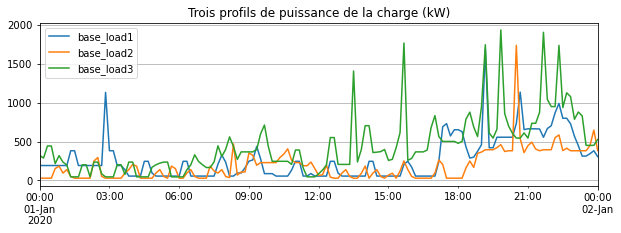

In [15]:
import matplotlib.pyplot as plt

data_charge[['base_load1', 'base_load2', 'base_load3']].plot(figsize=(10, 3), 
                                                             title='Trois profils de puissance de la charge (kW)')
plt.grid('on')

#### Index en chaîne de caractères

Si les données sont indexées par une chaine de caractère dont le format est celui d'une date. Dans ce cas, la date de début et l'unité ne sont pas utiles. La colonne d'index est parsée, utilisant le format définit dans date_parser.

In [16]:
data_pv = read_data(horizon, os.path.join(os.getcwd(), 'data', 'pv_2020.csv'),
                    usecols=[0, 2],
                    date_parser="%d/%m/%Y %H:%M")

data_pv.head(5)

,p_PV
2020-01-01 00:00:00+01:00,0.0
2020-01-01 00:10:00+01:00,0.0
2020-01-01 00:20:00+01:00,0.0
2020-01-01 00:30:00+01:00,0.0
2020-01-01 00:40:00+01:00,0.0


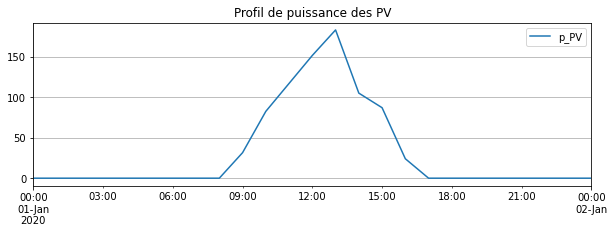

In [17]:
data_pv.plot(title='Profil de puissance des PV', figsize=(10, 3))
plt.grid('on')

In [18]:
load_data(horizon, m.pv.p, data_pv['p_PV'])
load_data(horizon, m.charge.p, data_charge['base_load1'])

data index and variable index does not have the same name. This could be a source of error...
data index and variable index does not have the same name. This could be a source of error...


In [19]:
# solver
#sol = SolverFactory('gurobi', solver_io="direct")
sol = SolverFactory('glpk')
res = sol.solve(m)

    (deprecated in 6.0) (called from /tmp/ipykernel_15322/3687727428.py:15)


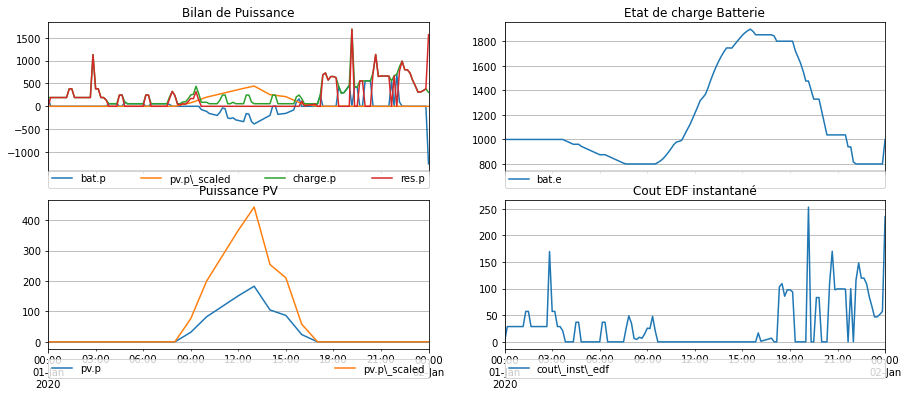

In [21]:
# post-processing
import matplotlib.pyplot as plt
from lms2.tools.post_processing import *

fig, ax = plt.subplots(nrows=2, ncols=2, sharex='all', figsize=(15, 6))
pplot(m.bat.p, m.pv.p_scaled, m.charge.p, m.res.p,
      ax=ax[0][0],
      title='Bilan de Puissance',
      fig=fig,
      index=horizon.current,
      bbox_to_anchor = (0, -0.12, 1, 0.2))

pplot(m.pv.p, m.pv.p_scaled, ax=ax[1][0], title='Puissance PV', fig=fig, index=horizon.current, bbox_to_anchor = (0, -0.2, 1, 0.2))
pplot(m.bat.e, ax=ax[0][1], title='Etat de charge Batterie', fig=fig, index=horizon.current, bbox_to_anchor = (0, -0.12, 1, 0.2))
pplot(m.cout_inst_edf, ax=ax[1][1], title='Cout EDF instantané', fig=fig, index=horizon.current, bbox_to_anchor = (0, -0.2, 1, 0.2))

plt.show()
